This is an continuation of the 2nd attempt at creating a reasonably good model for the Heart Disease dataset.
<br>
In the 2nd attempt, we arrive at models with a relatively good recall (0.78). But the precision drops to around 0.22. This is likely due to the precision-recall tradeoff.                                          

In [2]:
import pandas as pd
import dill

Import data and apply the same preprocessing as in exploration_2.ipynb

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('heart_2020_cleaned.csv')

# one-hot encoding
category_cols = [col for col in data.columns if data[col].dtype == 'object']
data = pd.get_dummies(data=data, columns=category_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(data.drop(['HeartDisease_Yes'], axis=1), data['HeartDisease_Yes'], test_size=0.2, random_state=42)

# this is the exact same as feature scaling in the 1st exploration
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)

Create different resampled datasets, just like in exploration_2.ipynb

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE


rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)

Let's try building bagging classifiers with each classifier balanced. Luckily, BalancedBaggingClassifier from imblearn implements this.

In [26]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

def cross_validate_bagging_diff_models_diff_data(models, resampling_methods, cv=3, n_estimators=10, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    scores_lst = []
    for m in models:
        for r in resampling_methods:
            bbc = BalancedBaggingClassifier(base_estimator=m, n_estimators=n_estimators, random_state=42)
            pipe = make_pipeline(r, bbc)
            print(f'now cross-validating {m.__class__.__name__} with {r.__class__.__name__}')
            scores = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring)
            scores_lst.append({k: round(v.mean(), 3) for k, v in scores.items()})
            print(f'Finished cross-validation for {r.__class__.__name__} with {m.__class__.__name__}')
    index = pd.MultiIndex.from_product([[m.__class__.__name__ for m in models], [r.__class__.__name__ for r in resampling_methods]], names=['model', 'resampling_method'])
    return pd.DataFrame(scores_lst, index=index)

In [27]:
from sklearn.linear_model import LogisticRegression

score_table = cross_validate_bagging_diff_models_diff_data(models=[LogisticRegression()], resampling_methods=[rus, ros, smote])
print(score_table)

now cross-validating LogisticRegression with RandomUnderSampler
Finished cross-validation for RandomUnderSampler with LogisticRegression
now cross-validating LogisticRegression with RandomOverSampler
Finished cross-validation for RandomOverSampler with LogisticRegression
now cross-validating LogisticRegression with SMOTE
Finished cross-validation for SMOTE with LogisticRegression
                                       fit_time  score_time  test_accuracy  \
model              resampling_method                                         
LogisticRegression RandomUnderSampler     2.603       1.277          0.751   
                   RandomOverSampler     27.948       1.264          0.750   
                   SMOTE                 35.913       1.267          0.750   

                                       test_precision  test_recall  test_f1  \
model              resampling_method                                          
LogisticRegression RandomUnderSampler           0.224        0.780  

Hmm, this is the identical result as in exploration_2.ipynb. Perhaps 10 estimators is not enough. Let's try 100 estimators.

In [28]:
score_table2 = cross_validate_bagging_diff_models_diff_data(models=[LogisticRegression()], resampling_methods=[rus, ros, smote], n_estimators=100)
print(score_table2)

now cross-validating LogisticRegression with RandomUnderSampler
Finished cross-validation for RandomUnderSampler with LogisticRegression
now cross-validating LogisticRegression with RandomOverSampler
Finished cross-validation for RandomOverSampler with LogisticRegression
now cross-validating LogisticRegression with SMOTE
Finished cross-validation for SMOTE with LogisticRegression
                                       fit_time  score_time  test_accuracy  \
model              resampling_method                                         
LogisticRegression RandomUnderSampler    19.489      11.782          0.751   
                   RandomOverSampler    251.231      10.338          0.750   
                   SMOTE                242.336      10.299          0.750   

                                       test_precision  test_recall  test_f1  \
model              resampling_method                                          
LogisticRegression RandomUnderSampler           0.224        0.780  

Hmm, increasing the number of estimators to 100 does not seem to give us an improvement in precision or recall. Let's plot the precision-recall curve to see if we can find a good tradeoff.

(0.0, 1.0)

C:\Users\danie\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


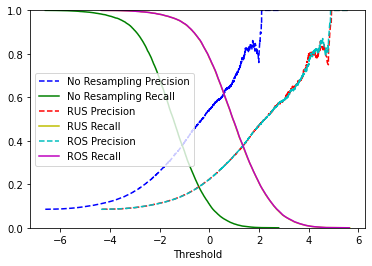

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

no_resampling_y_scores = cross_val_predict(LogisticRegression(), X_train, y_train, cv=3, method='decision_function')
no_resampling_precision, no_resampling_recall, no_resampling_thresholds = precision_recall_curve(y_train, no_resampling_y_scores)

rus_pipe = make_pipeline(rus, LogisticRegression())
rus_y_scores = cross_val_predict(rus_pipe, X_train, y_train, cv=3, method='decision_function')
rus_precision, rus_recall, rus_thresholds = precision_recall_curve(y_train, rus_y_scores)

ros_pipe = make_pipeline(ros, LogisticRegression())
ros_y_scores = cross_val_predict(ros_pipe, X_train, y_train, cv=3, method='decision_function')
ros_precision, ros_recall, ros_thresholds = precision_recall_curve(y_train, ros_y_scores)

plt.plot(no_resampling_thresholds, no_resampling_precision[:-1], 'b--', label='No Resampling Precision')
plt.plot(no_resampling_thresholds, no_resampling_recall[:-1], 'g-', label='No Resampling Recall')
plt.plot(rus_thresholds, rus_precision[:-1], 'r--', label='RUS Precision')
plt.plot(rus_thresholds, rus_recall[:-1], 'y-', label='RUS Recall')
plt.plot(ros_thresholds, ros_precision[:-1], 'c--', label='ROS Precision')
plt.plot(ros_thresholds, ros_recall[:-1], 'm-', label='ROS Recall')
plt.legend()
plt.xlabel('Threshold')
plt.ylim([0, 1])

* We see that the RUS precision is nearly identical to ROS precision and the RUS recall seems to be identical to ROS recall (they overlap entirely). This result agrees with the precision & recall scores in the above table (the scores are also identical).
* In addition, the no resampling precision-recall curve is very similar to the RUS and ROS precision-recall curves (they look like a horizontal transformation of each other). There is no precision-recall tradeoff improvement from resampling. 

Text(0, 0.5, 'Precision')

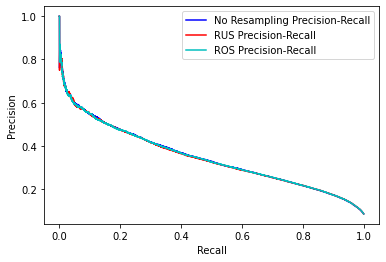

In [23]:
plt.plot(no_resampling_recall, no_resampling_precision, 'b-', label='No Resampling Precision-Recall')
plt.plot(rus_recall, rus_precision, 'r-', label='RUS Precision-Recall')
plt.plot(ros_recall, ros_precision, 'c-', label='ROS Precision-Recall')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')

The above plot confirms our understanding that there is no precision-recall tradeoff improvement from resampling. 

After experimenting with LogisticRegression. Let's try RandomForestClassifier on the resampled datasets as well as weighted XGBClassifier.

In [25]:
from imblearn.ensemble import BalancedRandomForestClassifier

brfc = BalancedRandomForestClassifier(random_state=42)
brfc_scores = cross_validate(brfc, X_train, y_train, cv=3, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])
brfc_scores = {k: round(v.mean(), 3) for k, v in brfc_scores.items()}
print(brfc_scores)

{'fit_time': 8.07, 'score_time': 3.81, 'test_accuracy': 0.72, 'test_precision': 0.2, 'test_recall': 0.79, 'test_f1': 0.32, 'test_roc_auc': 0.82}


The precision and recall of BalancedRandomForestClassifier do not improve. Let's try weighted XGBClassifier.

In [50]:
from xgboost import XGBClassifier

counts = y_train.value_counts()
scale_pos_weight = counts[0] / counts[1]
print(f'Scale pos weight: {scale_pos_weight}')

Scale pos weight: 10.745833524631559


In [51]:
from sklearn.model_selection import GridSearchCV

params = {'scale_pos_weight': [scale_pos_weight, 1, 50, 100]}

xgb = XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb, params, cv=3, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='recall')
xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_params_, xgb_grid.best_score_, xgb_grid.best_index_)
xgb_grid_result_df = pd.DataFrame(xgb_grid.cv_results_)
print(xgb_grid_result_df)

{'scale_pos_weight': 100} 0.9428399379858607 3
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      12.401772      1.109562         0.439892        0.047982   
1       9.986917      0.501229         0.385214        0.033976   
2      12.226962      1.563161         0.371774        0.012169   
3      10.077026      0.117753         0.359461        0.000104   

  param_scale_pos_weight                                    params  \
0              10.745834  {'scale_pos_weight': 10.745833524631559}   
1                      1                   {'scale_pos_weight': 1}   
2                     50                  {'scale_pos_weight': 50}   
3                    100                 {'scale_pos_weight': 100}   

   split0_test_accuracy  split1_test_accuracy  split2_test_accuracy  \
0              0.761676              0.759202              0.760278   
1              0.915255              0.915548              0.914855   
2              0.533179              0.529321        

In [52]:
xgb_grid_result_df.loc[xgb_grid.best_index_, ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']]

mean_test_accuracy     0.436322
mean_test_precision    0.125603
mean_test_recall        0.94284
mean_test_f1           0.221674
mean_test_roc_auc      0.817996
Name: 3, dtype: object

The best XGB estimator is ranked by recall. Now let's run grid search again but this time rank by roc_auc.

In [53]:
xgb_grid2 = GridSearchCV(xgb, params, cv=3, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='roc_auc')
xgb_grid2.fit(X_train, y_train)
print(xgb_grid2.best_params_, xgb_grid2.best_score_, xgb_grid2.best_index_)
xgb_grid_result_df2 = pd.DataFrame(xgb_grid.cv_results_)
print(xgb_grid_result_df2)

{'scale_pos_weight': 1} 0.8354273301450664 1
   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      12.401772      1.109562         0.439892        0.047982   
1       9.986917      0.501229         0.385214        0.033976   
2      12.226962      1.563161         0.371774        0.012169   
3      10.077026      0.117753         0.359461        0.000104   

  param_scale_pos_weight                                    params  \
0              10.745834  {'scale_pos_weight': 10.745833524631559}   
1                      1                   {'scale_pos_weight': 1}   
2                     50                  {'scale_pos_weight': 50}   
3                    100                 {'scale_pos_weight': 100}   

   split0_test_accuracy  split1_test_accuracy  split2_test_accuracy  \
0              0.761676              0.759202              0.760278   
1              0.915255              0.915548              0.914855   
2              0.533179              0.529321          

In [54]:
xgb_grid_result_df2.loc[xgb_grid2.best_index_, ['mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']]

mean_test_accuracy     0.915219
mean_test_precision    0.510427
mean_test_recall       0.100913
mean_test_f1           0.168464
mean_test_roc_auc      0.835427
Name: 1, dtype: object

From the initial grid search, it seems like increasing scale_pos_weight trades more recall for precision. For scale_pos_weight = 100, we get a recall of 0.943 and a precision of 0.126. This is not actually a good result: a dummy model that always predict "YES" will have recall of 0.9 and precision of 0.1 (this is because the number of "NO" is approx. 10 times the number of "YES").
<br>
Again, we favor recall over precision in this project because we want as many patients with heart disease to be detected.

In [55]:
# save all the models and results
dill.dump_session('exploration_3.db')